<a href="https://colab.research.google.com/github/Mario-RJunior/olist-e-commerce/blob/reviews/reviews_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# An√°lise dos Reviews

## 1) Introdu√ß√£o
Uma importante abordagem ao trabalhar com an√°lise de dados de uma base comercial √© justamente o feedback dos consumidores no que diz respeito √† qualidade dos produtos, ao atendimento, etc. e a neste sentido √© de suma import√¢ncia ter uma base de dados que tenham essas informa√ß√µes, uma vez que elas ajudam a melhorar a qualidade do servi√ßo.

Aqui n√£o √© diferente e neste notebook trabalharemos com uma base contendo, entre outros, os reviews dos clientes acerca dos produtos e uma nota atribuida a ele. Assim, utilizaremos alguns algor√≠tmos de Processamento de Linguagem Natural (em ingl√™s NPL) para fazer um classificador de sentimento, ou seja, determinar se um determinado review √© positivo ou negativo.

Portanto, a partir da pr√≥xima se√ß√£o iremos dar in√≠cio a esta etapa do estudo.

## 2) Carregando e explorando os dados

In [98]:
# Importando bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [99]:
# Carregando a base de dados
link = 'https://raw.githubusercontent.com/Mario-RJunior/olist-e-commerce/master/datasets/olist_order_reviews_dataset.csv'
reviews = pd.read_csv(link)

In [100]:
# Visualizando o cabe√ßalho
reviews.head()

review_id  ... review_answer_timestamp
0  7bc2406110b926393aa56f80a40eba40  ...     2018-01-18 21:46:59
1  80e641a11e56f04c1ad469d5645fdfde  ...     2018-03-11 03:05:13
2  228ce5500dc1d8e020d8d1322874b6f0  ...     2018-02-18 14:36:24
3  e64fb393e7b32834bb789ff8bb30750e  ...     2017-04-21 22:02:06
4  f7c4243c7fe1938f181bec41a392bdeb  ...     2018-03-02 10:26:53

[5 rows x 7 columns]

In [101]:
# Verificando o shape do dataframe
reviews.shape

(100000, 7)

Devido ao tamanho muito grande do dataset, iremos pegar apenas uma amostra do mesmo afim de reduzir os custos computacionais, que neste caso √© significativo.

Por conveni√™ncia, iremos considerar 40% dos dados originais.

In [103]:
# Gerando amostra do dataset
reviews_sample = reviews.sample(frac=0.5, random_state=2)

# Reindexando os registros
reviews_sample = reviews_sample.reset_index()

# Mostrando novo dataset
reviews_sample.head()

index  ... review_answer_timestamp
0   6448  ...     2017-04-19 21:39:51
1  50680  ...     2018-01-30 13:14:50
2    814  ...     2017-10-23 18:49:42
3  20354  ...     2018-05-04 10:44:20
4  49224  ...     2018-06-29 19:39:14

[5 rows x 8 columns]

In [104]:
# Visualizando o shape
reviews_sample.shape

(50000, 8)

In [105]:
# Retornando informa√ß√µes sobre o dataframe
reviews_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   index                    50000 non-null  int64 
 1   review_id                50000 non-null  object
 2   order_id                 50000 non-null  object
 3   review_score             50000 non-null  int64 
 4   review_comment_title     5834 non-null   object
 5   review_comment_message   20779 non-null  object
 6   review_creation_date     50000 non-null  object
 7   review_answer_timestamp  50000 non-null  object
dtypes: int64(2), object(6)
memory usage: 3.1+ MB


In [106]:
# Retornando algumas estat√≠sticas
reviews_sample.describe()

index  review_score
count  50000.000000  50000.000000
mean   49932.988020      4.073900
std    28936.406609      1.362496
min        0.000000      1.000000
25%    24674.750000      4.000000
50%    49915.500000      5.000000
75%    75162.250000      5.000000
max    99997.000000      5.000000

In [107]:
# Verificando valores faltantes
reviews_sample.isna().sum()

index                          0
review_id                      0
order_id                       0
review_score                   0
review_comment_title       44166
review_comment_message     29221
review_creation_date           0
review_answer_timestamp        0
dtype: int64

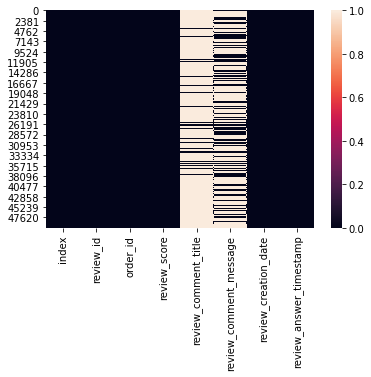

In [108]:
# Visualizando valores faltantes com heatmap
sns.heatmap(data=reviews_sample.isnull());

Confirmamos que h√° uma grande quantidade de valores faltantes.

In [109]:
# Visualizando alguns coment√°rios
reviews_sample['review_comment_message']

0        Produto entregue antes do prazo. Servi√ßo e pro...
1                                                      NaN
2        √≥tima compra\r\nmas o frete nao compensa,pesa ...
3                                                      NaN
4        Produto veio com defeito n√£o funciona, bem vou...
                               ...                        
49995    O produto at√© agora n√£o fez efeito espero que ...
49996    A descri√ß√£o do produto refere-se a um material...
49997                                                  NaN
49998    Produto correto e bem embalado. Chegou antes d...
49999                                                  NaN
Name: review_comment_message, Length: 50000, dtype: object

In [110]:
# Visualizando alguns t√≠tulos dos coment√°rios
reviews_sample['review_comment_title'].unique()

array([nan, 'Produto veio com defeito', 'Super recomendo', ...,
       'Problema', 'Toalhas de banho', 'Propaganda n√£o condiz '],
      dtype=object)

In [111]:
# N√∫mero de t√≠tulos n√£o √∫nicos
reviews_sample['review_comment_title'].nunique()

2580

In [113]:
# Contagem dos scores
reviews_sample['review_score'].value_counts()

5    28883
4     9470
1     5969
3     4075
2     1603
Name: review_score, dtype: int64

Podemos ainda fazer um histograma para verificar a ocorr√™ncia dos scores.

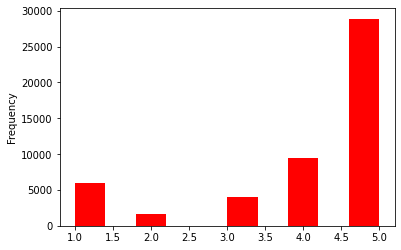

In [115]:
# # Plotando histograma
reviews_sample['review_score'].plot(kind='hist', color='r');

### Adicionando coluna para classifica√ß√£o

No dataframe reviews temos a coluna "review_score" que representa as notas (de 1 a 5) para os servi√ßos oferecidos. Neste caso, como queremos criar um classificador bin√°rio para os coment√°rios (positivos e negativos) devemos ent√£o gerar esta classifica√ß√£o baseado no score dado para cada coment√°rio. Assim, tomaremos o seguinte crit√©rio:

- scores 1, 2 e 3: coment√°rio negativo = 0;
- scores 4 e 5: coment√°rio positivo = 1.

Desta forma, adicionaremos a coluna "feedback" com a respectiva classifica√ß√£o para cada coment√°rio.

In [ ]:
# Adicionando a coluna "feedback"
reviews_sample['feedback'] = reviews_sample['review_score'].apply(lambda x: 1 if x >= 4 else 0)

In [ ]:
# Verificando o dataframe com a nova coluna
reviews_sample

review_id  ... feedback
6448   65e87641e147cd476cb45db794709d96  ...        1
50680  81cc7b52760844d20c4afeab2c71834c  ...        1
814    397f27a0d2936d02d3447864e0398414  ...        0
20354  5835427026f36ce691ad96313bddfe91  ...        1
49224  7751f2853341c4c59f589164fc02898c  ...        0
...                                 ...  ...      ...
34197  ae0c4bea81f7dda866bd1ba12d235213  ...        0
57789  c4e29cfc5265e1b2200f063ab60405a7  ...        1
96663  3be4d9828f24b3567084677feff43908  ...        1
92710  a5e4ad45d1d943c92d14fd0193e8d752  ...        1
12739  a9650dcdce4c10a3aaa71f343452873c  ...        0

[40000 rows x 8 columns]

Agora precisamos eliminar as colunas do dataframe que n√£o ser√£o utilizadas. Logo, deixaremos apenas as colunas "review_comment_message" e "feedback".

In [ ]:
# Deletando colunas desnecess√°rias
reviews_sample = reviews_sample.drop(columns=['review_id', 'order_id', 'review_score', 
                                'review_comment_title', 'review_creation_date',	
                                'review_answer_timestamp'], axis=1)

# Visualizando o cabe√ßalho
reviews_sample.head()

review_comment_message  feedback
6448   Produto entregue antes do prazo. Servi√ßo e pro...         1
50680                                                NaN         1
814    √≥tima compra\r\nmas o frete nao compensa,pesa ...         0
20354                                                NaN         1
49224  Produto veio com defeito n√£o funciona, bem vou...         0

In [ ]:
# Deletando registros com valores faltantes
reviews_sample.dropna(inplace=True)

In [ ]:
# Visualizando o cabe√ßalho
reviews_sample.head()

review_comment_message  feedback
6448   Produto entregue antes do prazo. Servi√ßo e pro...         1
814    √≥tima compra\r\nmas o frete nao compensa,pesa ...         0
49224  Produto veio com defeito n√£o funciona, bem vou...         0
91607                 satisfeita com a compra realizada.         1
13542                         OBRIGADA PELO ATENDIMENTO!         1

In [ ]:
# Visualizando o novo shape do dataframe
reviews_sample.shape

(16551, 2)

Podemos confirmar que o novo dataframe n√£o tem valores faltantes pelo heatmap.

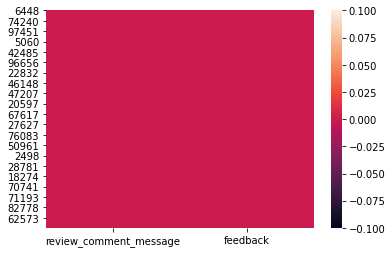

In [ ]:
# Heatmap
sns.heatmap(data=reviews_sample.isnull());

In [ ]:
reviews_sample.isnull().sum()

review_comment_message    0
feedback                  0
dtype: int64

Podemos plotar um histograma da coluna "feedback".

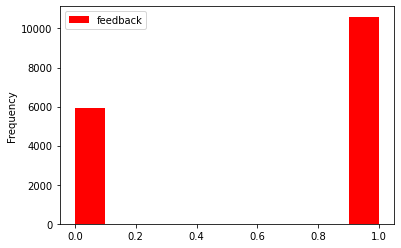

In [ ]:
reviews_sample.plot(kind='hist', color='r');

Podemos ainda adicionar mais uma estat√≠stica para entendermos melhor os nossos dados. Neste caso, iremos verificar qual √©, em m√©dia, o n√∫mero de caracteres de cada coment√°rio. Criaremos ent√£o, outro dataframe para este fim.

In [ ]:
# Cria√ß√£o do novo dataframe
reviews_character_length = reviews_sample.copy() 

# Criando a coluna com o n√∫mero de caracteres
reviews_character_length['length'] = reviews_sample['review_comment_message'].apply(len)

In [ ]:
# Visualizando o cabe√ßalho
reviews_character_length

review_comment_message  feedback  length
6448   Produto entregue antes do prazo. Servi√ßo e pro...         1      78
814    √≥tima compra\r\nmas o frete nao compensa,pesa ...         0      83
49224  Produto veio com defeito n√£o funciona, bem vou...         0     137
91607                 satisfeita com a compra realizada.         1      34
13542                         OBRIGADA PELO ATENDIMENTO!         1      26
...                                                  ...       ...     ...
80170  Eu n√£o recebi o xale do sof√°, por√©m ao ligar, ...         0      67
56009          Amei!\r\nS√£o lindos e de √≥tima qualidade!         1      39
34197  J√° paguei faz tempo, estou precisando √© ainda ...         0      69
96663  Entrega recebida bem antestreia do prazo estab...         1      53
92710    Ainda n√£o usei o produto mas tudo foi certinho          1      47

[16551 rows x 3 columns]

In [ ]:
# Estat√≠sticas de reviews_character_length
reviews_character_length.describe()

feedback        length
count  16551.000000  16551.000000
mean       0.640445     70.568244
std        0.479885     55.347758
min        0.000000      1.000000
25%        0.000000     29.000000
50%        1.000000     54.000000
75%        1.000000     98.000000
max        1.000000    204.000000

In [ ]:
# Checando alguns reviews
reviews_character_length.query('length == 1')

review_comment_message  feedback  length
18609                      .         1       1
11749                      .         1       1
90773                      .         1       1
50288                      S         0       1
19036                      s         1       1
47352                      I         1       1
91000                      .         1       1
60844                      .         1       1
74469                      s         1       1
77590                      .         0       1
1603                       X         1       1
90744                      o         1       1
3845                       .         1       1
92797                      .         1       1
98334                      -         1       1
10718                      .         1       1
65788                      m         0       1
14679                      *         1       1
62889                      -         1       1
82731                      .         0       1
61627                      .         1       1
22151                      .         1       1
23341                      .         1       1
54657                      ?         1       1
83858                      .         1       1
42201                      -         1       1
60108                      .         1       1
62397                      .         1       1
56475                      üëç         1       1
65884                      .         1       1
58600                      5         0       1
72798                      5         1       1
78336                      *         1       1
88075                      .         1       1
51449                      A         0       1
66687                      .         1       1
78141                      o         1       1
4373                       .         1       1
15073                      .         1       1
70659                      O         0       1
84380                      Y         1       1
28340                      üòÄ         1       1
8937                       .         1       1
66726                      .         1       1

In [ ]:
# Verificando a quantidade de caracteres √∫nicos
reviews_character_length.query('length == 1')['review_comment_message'].value_counts()

.    23
-     3
*     2
5     2
o     2
s     2
?     1
üòÄ     1
O     1
üëç     1
Y     1
A     1
I     1
S     1
X     1
m     1
Name: review_comment_message, dtype: int64

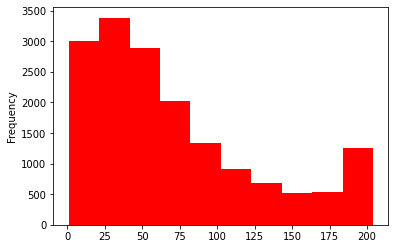

In [ ]:
# Histograma para o tamanho dos reviews
reviews_character_length['length'].plot(kind='hist', color='r');

### Reviews positivos e negativos

Iremos agora gerar dataframes com reviews positivos e negativos e comparar ambos.

In [ ]:
# Dataframe negativo
negative = reviews_character_length.query('feedback == 0')
negative.head()

review_comment_message  feedback  length
814    √≥tima compra\r\nmas o frete nao compensa,pesa ...         0      83
49224  Produto veio com defeito n√£o funciona, bem vou...         0     137
41384  No site consta como entregue, por√©m N√ÉO recebi...         0      52
51964  Comprei como srmpre fa√ßo. Por√©m dessa vez o pr...         0     131
12574  O produto n√£o foi entregue. Nem se quer chegou...         0      56

In [ ]:
# Shape
negative.shape

(5951, 3)

In [ ]:
# Visualizando estat√≠stica
negative.describe()

feedback       length
count    5951.0  5951.000000
mean        0.0    98.157957
std         0.0    61.112536
min         0.0     1.000000
25%         0.0    46.000000
50%         0.0    87.000000
75%         0.0   151.000000
max         0.0   204.000000

In [ ]:
# Dataframe positivo
positive = reviews_character_length.query('feedback == 1')
positive.head()

review_comment_message  feedback  length
6448   Produto entregue antes do prazo. Servi√ßo e pro...         1      78
91607                 satisfeita com a compra realizada.         1      34
13542                         OBRIGADA PELO ATENDIMENTO!         1      26
28221  Atendimento especial,adorei comprar nas lojas ...         1     139
75385                                          Muito bom         1       9

In [ ]:
# Shape
positive.shape

(10600, 3)

In [ ]:
# Visualizando estat√≠stica
positive.describe()

feedback        length
count   10600.0  10600.000000
mean        1.0     55.078962
std         0.0     44.938285
min         1.0      1.000000
25%         1.0     23.000000
50%         1.0     43.000000
75%         1.0     73.000000
max         1.0    204.000000

Vemos que os coment√°rios negativos √©, em m√©dia, maior do que os positivos e um motivo plaus√≠vel √© a possibilidade de as pessoas com queixas do servi√ßo explicarem mais detalhadamente sua insatisfa√ß√£o.

### Nuvem de palavras

Agora, criaremos duas nuvens de palavra para cada dataframe (positivo e negativo) para entendermos quais palavras mais se destacam em ambos os casos. Para isso, devemos colocar todos os reviews como se fosse uma string apenas. Ent√£o, temos o seguinte c√≥digo com este prop√≥sito.

- Reviews positivos

In [ ]:
# Colocando reviews positivos em uma lista
positive_reviews = positive['review_comment_message'].tolist()

# Visualizando os 5 primeiros reviews
positive_reviews[0:5]

['Produto entregue antes do prazo. Servi√ßo e produto 100% atendidos. Parab√©ns!!!',
 'satisfeita com a compra realizada.',
 'OBRIGADA PELO ATENDIMENTO!',
 'Atendimento especial,adorei comprar nas lojas lannister pelo site o produto veio correto.Parab√©ns pelo desempenho.Sou um cliente satisfeito',
 'Muito bom']

In [ ]:
# Juntando em apenas uma string
sentence_as_one_string = ' '.join(positive_reviews)

Gerando a nuvem de palavras.

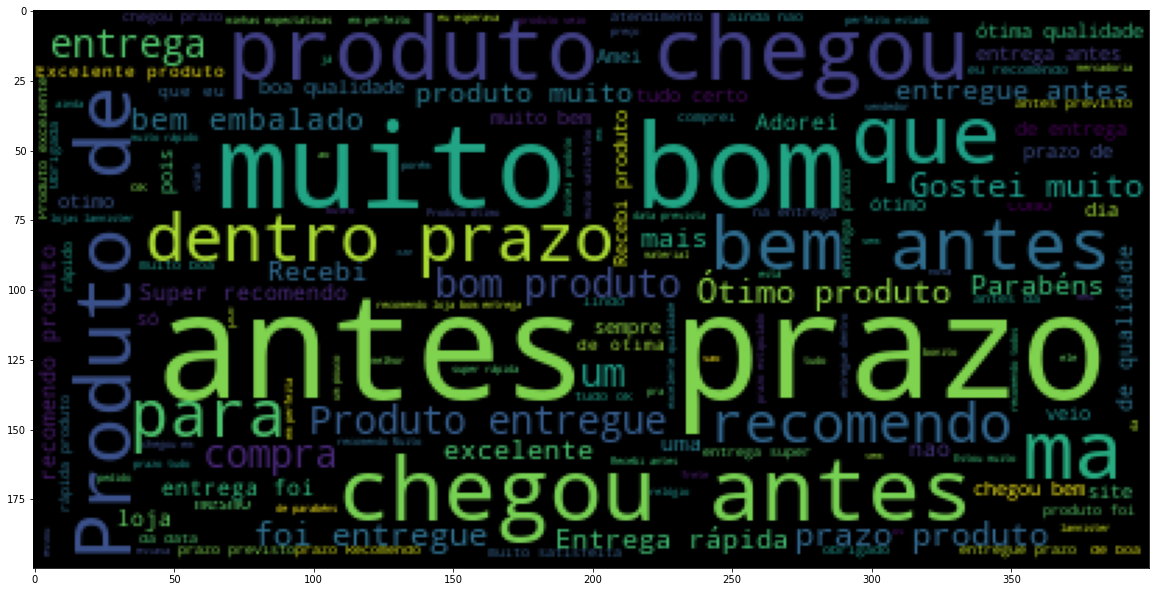

In [ ]:
# Importando a biblioteca
from wordcloud import WordCloud

# Gerando a imagem
plt.figure(figsize=(20,20))
plt.imshow(WordCloud().generate(sentence_as_one_string));

- Reviews negativos

In [ ]:
# Colocando reviews negativos em uma lista
negative_reviews = negative['review_comment_message'].tolist()

# Visualizando os 5 primeiros reviews
negative_reviews[0:5]

['√≥tima compra\r\nmas o frete nao compensa,pesa no or√ßamento.\r\ndevia ter frete grates\r\n',
 'Produto veio com defeito n√£o funciona, bem vou pedir troca, o pre√ßo n√£o vale a dor de cabe√ßa, fui em uma el√©trica e comprei um prestasse.',
 'No site consta como entregue, por√©m N√ÉO recebi nada.',
 'Comprei como srmpre fa√ßo. Por√©m dessa vez o produto ficou retido no correio de outro munic√≠pio e n√£o entre em casa como de costume.',
 'O produto n√£o foi entregue. Nem se quer chegou em casa. ']

In [ ]:
# Juntando em apenas uma string
negative_sentence_as_one_string = ' '.join(negative_reviews)

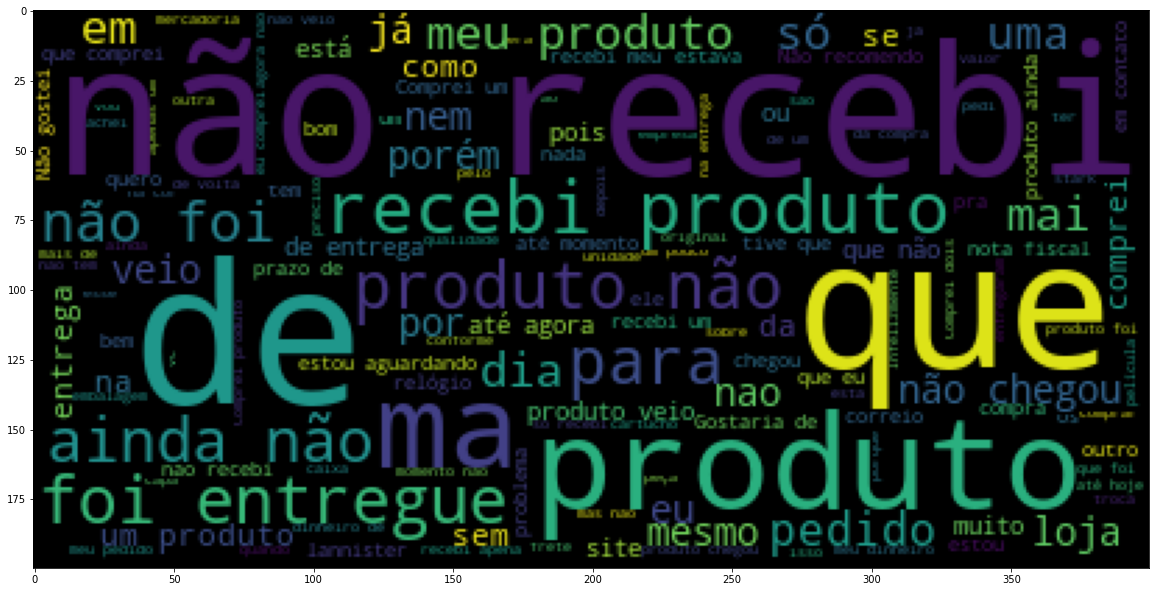

In [ ]:
# Gerando a imagem
plt.figure(figsize=(20,20))
plt.imshow(WordCloud().generate(negative_sentence_as_one_string));

## Remo√ß√£o de pontua√ß√£o

Para criar o modelo preditivo de sentimento precisamos tratar os dados (da coluna reviews) e o tratamento neste caso consiste na remo√ß√£o de pontua√ß√£o e das chamadas "stop words". Inicialmente iremos tratar a pontua√ß√£o para, na pr√≥xima se√ß√£o, tratar as stop words.

In [ ]:
# Importando a bibliotecas
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

Podemos fazer um teste com um review para termos certeza que o c√≥digo servir√° para nosso prop√≥sito.

In [ ]:
# Selecionando um review qualquer do dataframe
test = reviews_sample['review_comment_message'].iloc[200]
test

'No prazo, como sempre!!!!!!!'

In [ ]:
test_punct = [letra for letra in test if letra not in string.punctuation]
print(test_punct)

['N', 'o', ' ', 'p', 'r', 'a', 'z', 'o', ' ', 'c', 'o', 'm', 'o', ' ', 's', 'e', 'm', 'p', 'r', 'e']


Note que removemos a pontua√ß√£o do review original. Agora, podemos junt√°-lo novamente em uma frase sem tais pontua√ß√µes.

In [ ]:
# Juntando novamente a frase
test_punct = ''.join(test_punct)
print(test_punct)

No prazo como sempre


## Remo√ß√£o de stop words

Agora iremos remover as stop words, ou seja, aquelas palavras que n√£o contruibuem para o significado positivou ou negativo dos reviews.

In [ ]:
# Importando a biblioteca
import nltk

In [ ]:
# Fazendo download de alguns pacotes
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Como os textos est√£o em portugu√™s, precisamos baixar as stop words no mesmo idioma e para isso importaremos uma biblioteca espec√≠fica do pacote ***nltk***.

In [ ]:
# Importando bibliotecas
from nltk.corpus import stopwords

# Stop words em portugu√™s
print(stopwords.words('portuguese'))


['de', 'a', 'o', 'que', 'e', '√©', 'do', 'da', 'em', 'um', 'para', 'com', 'n√£o', 'uma', 'os', 'no', 'se', 'na', 'por', 'mais', 'as', 'dos', 'como', 'mas', 'ao', 'ele', 'das', '√†', 'seu', 'sua', 'ou', 'quando', 'muito', 'nos', 'j√°', 'eu', 'tamb√©m', 's√≥', 'pelo', 'pela', 'at√©', 'isso', 'ela', 'entre', 'depois', 'sem', 'mesmo', 'aos', 'seus', 'quem', 'nas', 'me', 'esse', 'eles', 'voc√™', 'essa', 'num', 'nem', 'suas', 'meu', '√†s', 'minha', 'numa', 'pelos', 'elas', 'qual', 'n√≥s', 'lhe', 'deles', 'essas', 'esses', 'pelas', 'este', 'dele', 'tu', 'te', 'voc√™s', 'vos', 'lhes', 'meus', 'minhas', 'teu', 'tua', 'teus', 'tuas', 'nosso', 'nossa', 'nossos', 'nossas', 'dela', 'delas', 'esta', 'estes', 'estas', 'aquele', 'aquela', 'aqueles', 'aquelas', 'isto', 'aquilo', 'estou', 'est√°', 'estamos', 'est√£o', 'estive', 'esteve', 'estivemos', 'estiveram', 'estava', 'est√°vamos', 'estavam', 'estivera', 'estiv√©ramos', 'esteja', 'estejamos', 'estejam', 'estivesse', 'estiv√©ssemos', 'estivessem', '

In [ ]:
# Verificando a quantidade de stop words
len(stopwords.words('portuguese'))

204

Podemos agora testar a remo√ß√£o de stop words para o review de teste que criamos acima.

In [ ]:
# Removendo stopwords do review de teste
test_punct = [word for word in test_punct.split() if word.lower() not in stopwords.words('portuguese')]

In [ ]:
# Verificando o resultado
test_punct

['prazo', 'sempre']

## Count vectorization (tokeniza√ß√£o)

Nesta se√ß√£o faremos o processo de tokenia√ß√£o, ou seja, iremos converter cada palavras em n√∫meros e fazer uma contagem de cada uma delas para verifica sua ocorr√™ncia em uma frase.

In [ ]:
# Importando a biblioteca
from sklearn.feature_extraction.text import CountVectorizer

Ulitilizando a frase de testes acima para verifica√ß√£o.

In [ ]:
# Criando um objeto para vetoriza√ß√£o
vectorizer = CountVectorizer()

# Aplicando √† frase de testes
x = vectorizer.fit_transform(test_punct)

In [ ]:
# Verificando o resultado
x

<2x2 sparse matrix of type '<class 'numpy.int64'>'
	with 2 stored elements in Compressed Sparse Row format>

In [ ]:
# Verificando as palavras vetorizadas
vectorizer.get_feature_names()

['prazo', 'sempre']

In [ ]:
# Visualizando a matriz resultante
x.toarray()

array([[1, 0],
       [0, 1]])

## Pipeline para limpeza de dados

Agora sim iremos aplicar os c√≥digos escritos acima para toda a base de dados.

In [ ]:
# Criando a fun√ß√£o
def message_cleaning(message):
  # text = re.sub(r'\.+', ' ', message)
  text = [char for char in message if char not in string.punctuation]
  text = ''.join(text)
  text = [word for word in text.split() if word.lower() not in stopwords.words('portuguese')]
  return text

In [ ]:
# Aplicando a fun√ß√£o no dataframe
reviews_df_clean = reviews_sample['review_comment_message'].apply(message_cleaning)

In [ ]:
# Visualizando o dataframe
reviews_df_clean

6448     [Produto, entregue, antes, prazo, Servi√ßo, pro...
814      [√≥tima, compra, frete, nao, compensapesa, or√ßa...
49224    [Produto, veio, defeito, funciona, bem, vou, p...
91607                      [satisfeita, compra, realizada]
13542                              [OBRIGADA, ATENDIMENTO]
                               ...                        
80170    [recebi, xale, sof√°, por√©m, ligar, consta, rec...
56009                     [Amei, lindos, √≥tima, qualidade]
34197    [paguei, faz, tempo, precisando, ainda, recebi...
96663    [Entrega, recebida, bem, antestreia, prazo, es...
92710               [Ainda, usei, produto, tudo, certinho]
Name: review_comment_message, Length: 16551, dtype: object

In [ ]:
# Fazendo a vectoriza√ß√£o
vectorizer = CountVectorizer(analyzer=message_cleaning)
reviews_countvectorizer = vectorizer.fit_transform(reviews_sample['review_comment_message'])

In [ ]:
# Vendo as palavras √∫nicas
print(vectorizer.get_feature_names())

['0', '00', '000000000000000000000000000', '000024453', '001689', '003566', '003570', '01', '01032018', '0106', '01062017', '0109', '010918', '01092017', '01122017', '012495', '0162017', '0163750232', '0163751255', '0164784672', '0165096389', '0165465041', '0166709005', '0166821151neste', '0168759427', '01um', '02', '0201', '020218', '02032018', '020617', '02082018', '02645364747', '02649450934', '02653047820', '02654859320', '02655871733', '02657469076', '02657530904', '02658697704', '02664287063', '02666377620', '03', '03012018', '03022018', '0303', '03032018', '0304', '03042017', '0305', '0307', '031117', '03497913106', '04', '0401', '0404', '0405', '04102016', '041217', '05', '0501', '05022018', '0503', '0504', '050717', '05092017', '0511', '05ml', '06', '060118', '06022018', '0603', '0604', '06042018', '0606', '060618', '06062018', '06072018', '0608', '060818', '06082018', '060cm', '0612', '062018', '07', '0702', '0705', '07052018S√≥', '0706', '07092018', '0712', '071217', '071220

In [ ]:
# Contagem de palavras √∫nicas
len(vectorizer.get_feature_names())

13858

In [ ]:
# Visualizando shape
reviews_countvectorizer.shape

(16551, 13858)